<a href="https://colab.research.google.com/github/alleludo-panji/KPSC/blob/main/KPSC_Implementasi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Anggota Kelompok

1. Alif Rafi Tulusena         - 22/498119/PA/21484
2. Tengku Syaid Farhan        - 22/493998/PA/21234
3. Alleludo Panji Dewa Atmaja - 21/478555/PA/20753


In [ ]:
# Instal library umum
!pip install pandas numpy matplotlib seaborn scikit-learn


# Environment

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim import corpora
from wordcloud import WordCloud

nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)


True

# Data Collection



In [ ]:
df = pd.read_parquet("hf://datasets/bunkalab/arxiv_topic_modeling/data/train-00000-of-00001.parquet")
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df.head()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,Title,Authors,Abstract,entry_id,Date,Categories,year,Year
0,Enhancing Knowledge Retrieval with Topic Model...,"Nhat Tran, Diane Litman",Knowledge retrieval is one of the major challe...,http://arxiv.org/abs/2405.04713v1,2024-05-07 23:32:32+00:00,cs.IR,2024,2024
1,Inferring Discussion Topics about Exploitation...,Felipe Moreno-Vera,The increasing sophistication of cyber threats...,http://arxiv.org/abs/2405.04561v1,2024-05-07 14:54:32+00:00,"cs.CR, cs.AI, cs.CY, cs.LG",2024,2024
2,Identifying Narrative Patterns and Outliers in...,"Maxim Ifergan, Renana Keydar, Omri Abend, Amit...",The vast collection of Holocaust survivor test...,http://arxiv.org/abs/2405.02650v1,2024-05-04 12:29:00+00:00,"cs.CL, cs.AI",2024,2024
3,A Named Entity Recognition and Topic Modeling-...,"Ayaz Mehmood, Muhammad Tayyab Zamir, Muhammad ...","Over the last decade, similar to other applica...",http://arxiv.org/abs/2405.00903v1,2024-05-01 23:19:49+00:00,cs.CL,2024,2024
4,Addressing Topic Granularity and Hallucination...,"Yida Mu, Peizhen Bai, Kalina Bontcheva, Xingyi...",Large language models (LLMs) with their strong...,http://arxiv.org/abs/2405.00611v1,2024-05-01 16:32:07+00:00,cs.CL,2024,2024


# Data Preprocessing

In [ ]:
# Text Preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

df['cleaned_text'] = df['Abstract'].apply(preprocess_text)

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_text'])

In [ ]:
df = df.dropna(subset=['cleaned_text'])
df = df[df['cleaned_text'].str.strip() != '']

In [ ]:
df = df[df['cleaned_text'].str.split().str.len() > 5]  # Removing abstracts with less than 5 words

In [ ]:
tokenized_texts = [text.split() for text in df['cleaned_text']]
bigram = Phrases(tokenized_texts, min_count=5, threshold=10)
trigram = Phrases(bigram[tokenized_texts], threshold=10)

bigram_model = Phraser(bigram)
trigram_model = Phraser(trigram)

df['cleaned_text'] = df['cleaned_text'].apply(lambda text: ' '.join(trigram_model[bigram_model[text.split()]]))

In [ ]:
# Create a dictionary and corpus for Gensim
texts = [text.split() for text in df['cleaned_text']]
dictionary = corpora.Dictionary(texts)

# Filter extremes to remove very common and very rare words
dictionary.filter_extremes(no_below=5, no_above=0.95, keep_n=5000)

# Convert to Bag-of-Words corpus
corpus = [dictionary.doc2bow(text) for text in texts]

# Save dictionary and corpus for DTM
dictionary.save('dtm_dictionary.dict')
corpora.MmCorpus.serialize('dtm_corpus.mm', corpus)

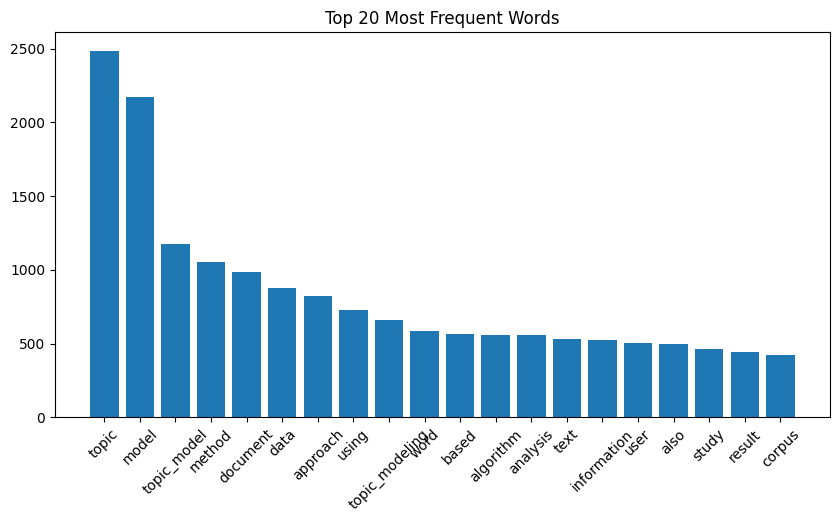

In [ ]:
# Visualize most frequent words
from collections import Counter
import matplotlib.pyplot as plt

word_counts = Counter(" ".join(df['cleaned_text']).split())
most_common_words = word_counts.most_common(20)

words, counts = zip(*most_common_words)
plt.figure(figsize=(10,5))
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title("Top 20 Most Frequent Words")
plt.show()


In [ ]:
# Convert corpus to DataFrame for easy access
dtm_df = pd.DataFrame({'id': range(len(corpus)), 'bow': corpus, 'cleaned_text': df['cleaned_text']})

In [ ]:
# Save processed dataset
df.to_csv('preprocessed_dtm_data.csv', index=False)

#Basic DTM Model (nanti revisi lagi)

In [ ]:
import gensim
from gensim.models import LdaSeqModel
from gensim.corpora import Dictionary

In [ ]:
# Load preprocessed dataset
df = pd.read_csv('preprocessed_dtm_data.csv')

# Load dictionary and corpus
dictionary = Dictionary.load('dtm_dictionary.dict')
corpus = gensim.corpora.MmCorpus('dtm_corpus.mm')

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year  # Extract year from Date column

# Get document counts per year
time_slices = df['Year'].value_counts().sort_index().tolist()  # Number of documents per time period

# Convert documents into list of tokenized words
texts = [text.split() for text in df['cleaned_text']]


In [ ]:
# Set number of topics
num_topics = 5

# Train the Dynamic Topic Model (DTM) using LDASeqModel
dtm = LdaSeqModel(corpus=corpus,
                  time_slice=time_slices,
                  id2word=dictionary,
                  num_topics=num_topics,
                  passes=10)

# Save the trained model
dtm.save('dtm_model')


/usr/local/lib/python3.11/dist-packages/gensim/models/ldaseqmodel.py:298: RuntimeWarning: divide by zero encountered in scalar divide
  convergence = np.fabs((bound - old_bound) / old_bound)


In [ ]:
# Load trained model
dtm = LdaSeqModel.load('dtm_model')

# Display topics at different time periods
for time_idx in range(len(time_slices)):  # Iterate over different time periods
    print(f"\n===== Topics in Time Slice {time_idx} =====")
    for topic_id in range(num_topics):
        print(f"Topic {topic_id}: {dtm.print_topic(topic=topic_id, time=time_idx)}")


===== Topics in Time Slice 0 =====
Topic 0: [('model', 0.01606428474568365), ('distribution', 0.012237091568385762), ('matrix', 0.0108795516188025), ('algorithm', 0.009442317433563262), ('data', 0.009134644938839576), ('topic_model', 0.007712114082178129), ('problem', 0.007582754651826998), ('method', 0.0067680316159433734), ('show', 0.006587757341234396), ('parameter', 0.006257804957464694), ('result', 0.0060125627552928915), ('mixture', 0.005849394940830685), ('assumption', 0.005758674120511106), ('learning', 0.0057137035039141314), ('k', 0.00561708528521893), ('latent', 0.005599832854870603), ('analysis', 0.005591356986848567), ('application', 0.005475997154277508), ('topic', 0.005472463538433214), ('number', 0.005006281921926025)]
Topic 1: [('topic', 0.04333670454692696), ('model', 0.02716109298157183), ('document', 0.013789646986045083), ('topic_model', 0.011720446272130652), ('method', 0.010984412947129474), ('approach', 0.010612775357759185), ('text', 0.007733034872377355), ('w

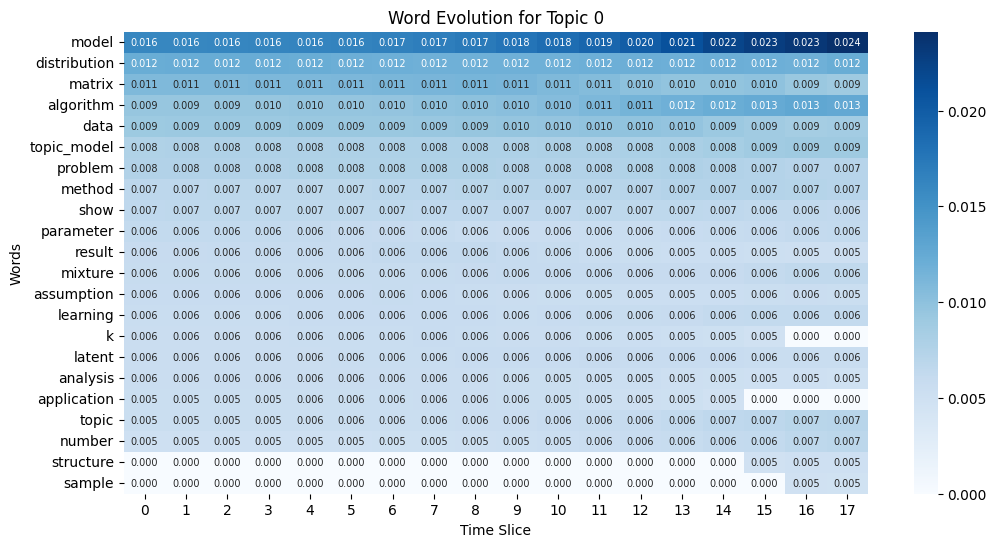

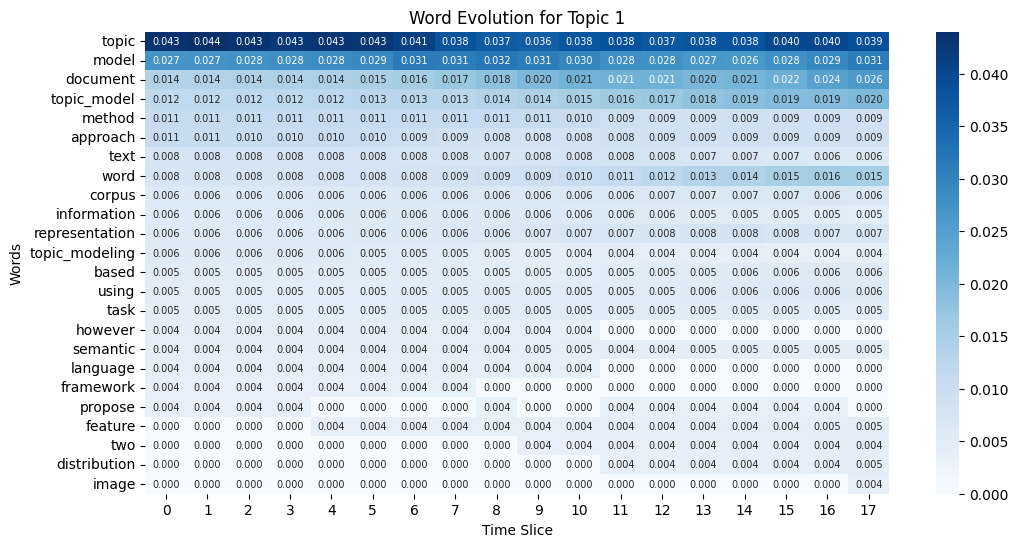

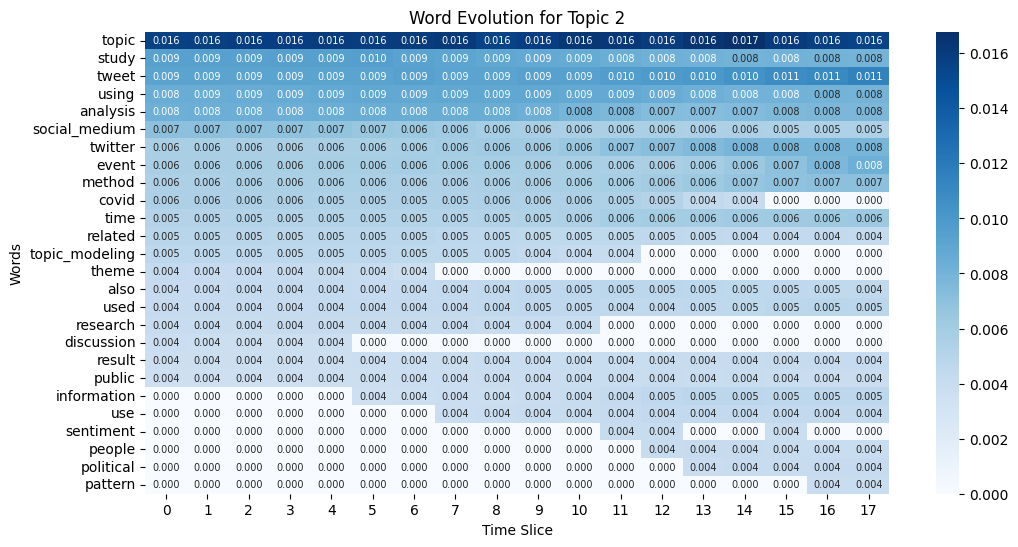

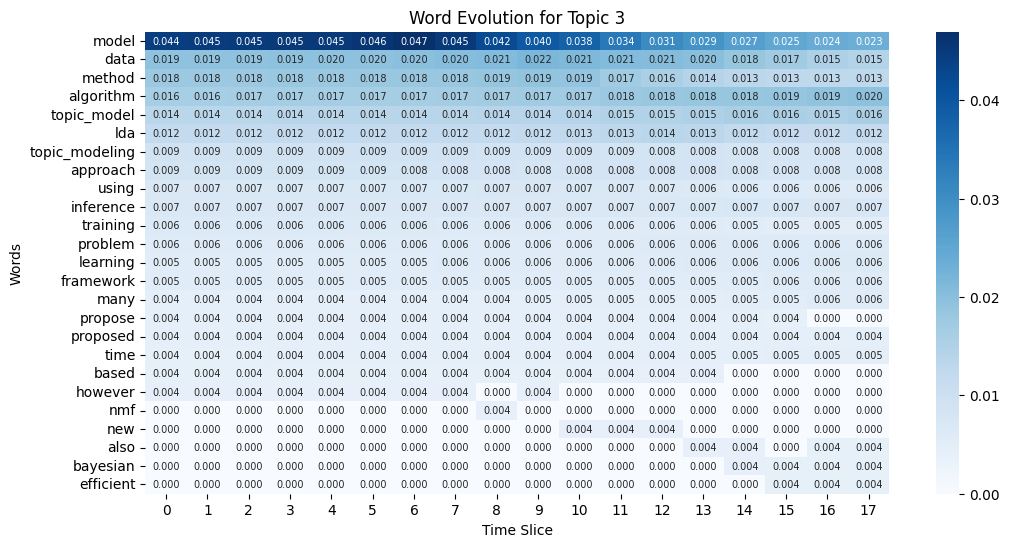

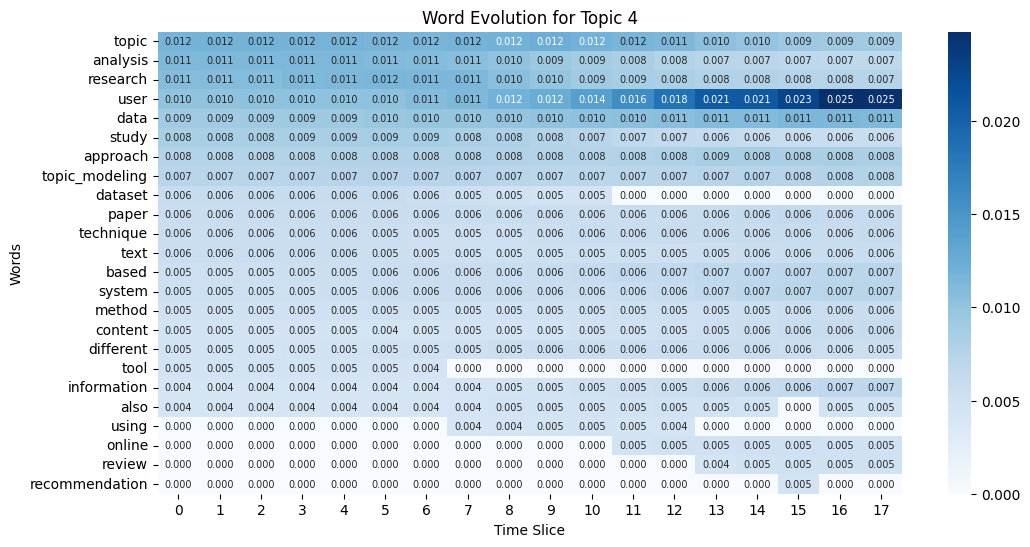

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming time_steps and dtm are already defined in your context
topic_ids = range(5)  # IDs 0 to 4
word_trends_all = {}

# Loop through each topic_id to extract word distributions over time
for topic_id in topic_ids:
    word_trends = {}

    for t in range(time_steps):
        words = dtm.print_topic(topic=topic_id, time=t)  # Get topic words over time

        # Check if words is a string and needs to be split manually
        if isinstance(words, str):
            words = words.split(" + ")  # Split topic words

            # Convert words into (weight, word) tuples
            words = [tuple(word.strip().split("*"))[::-1] for word in words]  # Reverse to (word, weight)

        # Now words should be a proper list of (word, weight) tuples
        for word, weight in words:
            try:
                weight = float(weight)  # Ensure weight is a float
                if word not in word_trends:
                    word_trends[word] = [0] * time_steps  # Initialize word trend list
                word_trends[word][t] = weight  # Store weight over time
            except ValueError:
                print(f"Skipping invalid weight: {weight} for word: {word}")

    # Convert to DataFrame for visualization
    word_trends_df = pd.DataFrame(word_trends, index=range(time_steps))
    word_trends_all[topic_id] = word_trends_df

# Plot word evolution for each topic individually
for i, topic_id in enumerate(topic_ids):
    plt.figure(figsize=(12, 6))  # Set figure size for each topic
    sns.heatmap(word_trends_all[topic_id].T, cmap="Blues", annot=True, fmt=".3f", annot_kws={"size": 7})
    plt.title(f"Word Evolution for Topic {topic_id}")
    plt.xlabel("Time Slice")
    plt.ylabel("Words")
    plt.show()  # Show each heatmap one by one

# Analysis of Results & Visual
## Topic Heat

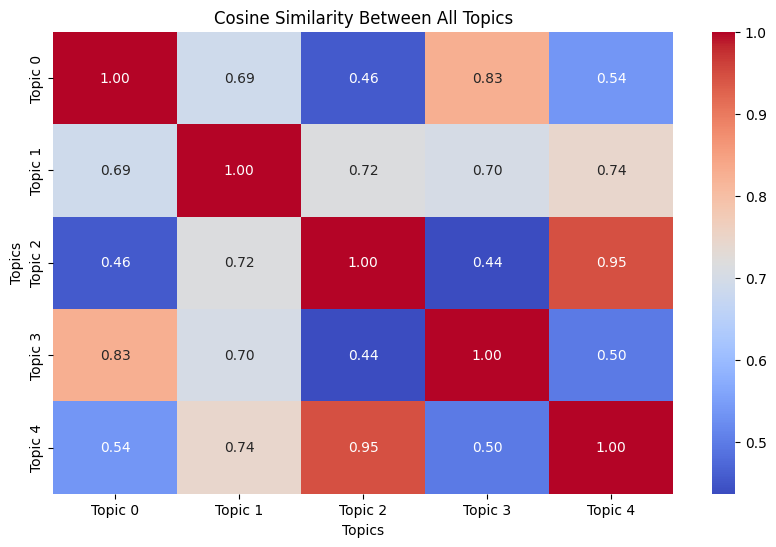

In [ ]:

from sklearn.metrics.pairwise import cosine_similarity

# Get topic distributions for all time slices
topic_distributions = []
for t in range(len(time_slices)):
    # Get topic proportions for each document at time t
    doc_topic_dist = [dtm.doc_topics(d) for d in range(len(corpus)) if df['Year'].iloc[d] == df['Year'].unique()[t]]
    # Average topic proportions to get overall topic distribution at time t
    topic_weights = np.mean(doc_topic_dist, axis=0) if doc_topic_dist else np.zeros(dtm.num_topics) # Handle empty time slices
    topic_distributions.append(topic_weights)

topic_distributions = np.array(topic_distributions).T  # Transpose so each row = topic


# Calculate cosine similarity for all topics
similarity_matrix = cosine_similarity(topic_distributions)  # Calculate similarity between all topics


# Create DataFrame for visualization
import pandas as pd
df_similarity = pd.DataFrame(similarity_matrix,
                              index=[f"Topic {i}" for i in range(topic_distributions.shape[0])],
                              columns=[f"Topic {i}" for i in range(topic_distributions.shape[0])])

# Plot Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_similarity, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Cosine Similarity Between All Topics")
plt.xlabel("Topics")
plt.ylabel("Topics")
plt.show()

<ipython-input-22-8e9744a9adf2>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[f"Topic {i}" for i in range(len(topic_counts))], y=topic_counts, palette="coolwarm")


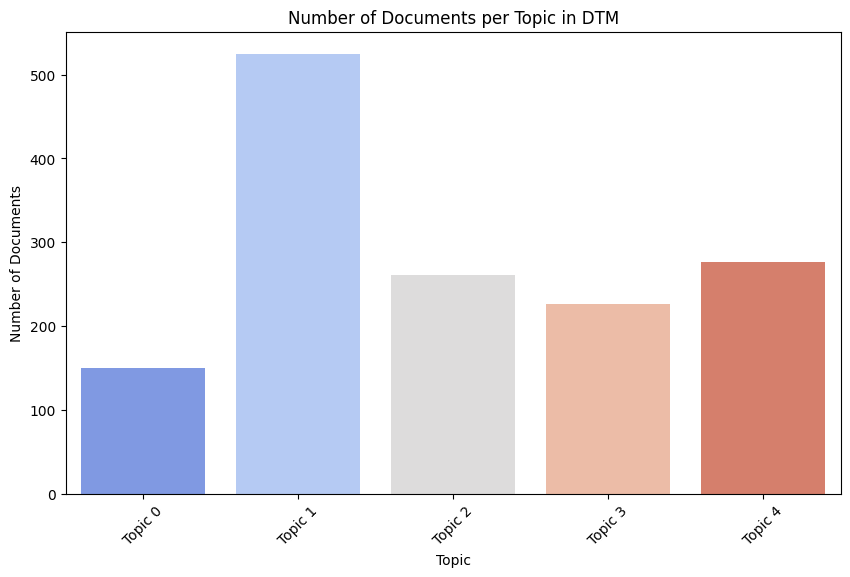

In [ ]:
# Get document-topic distributions for all documents
# Instead of using dtm.inference, iterate through documents and use dtm.doc_topics:
doc_topics = [dtm.doc_topics(doc_id) for doc_id in range(len(corpus))]

# Convert to a numpy array for further processing
doc_topics_arr = np.array(doc_topics)

# Calculate topic counts based on document-topic distributions
topic_counts = np.sum(doc_topics_arr, axis=0)

# Proceed with plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=[f"Topic {i}" for i in range(len(topic_counts))], y=topic_counts, palette="coolwarm")
plt.xlabel("Topic")
plt.ylabel("Number of Documents")
plt.title("Number of Documents per Topic in DTM")
plt.xticks(rotation=45)
plt.show()

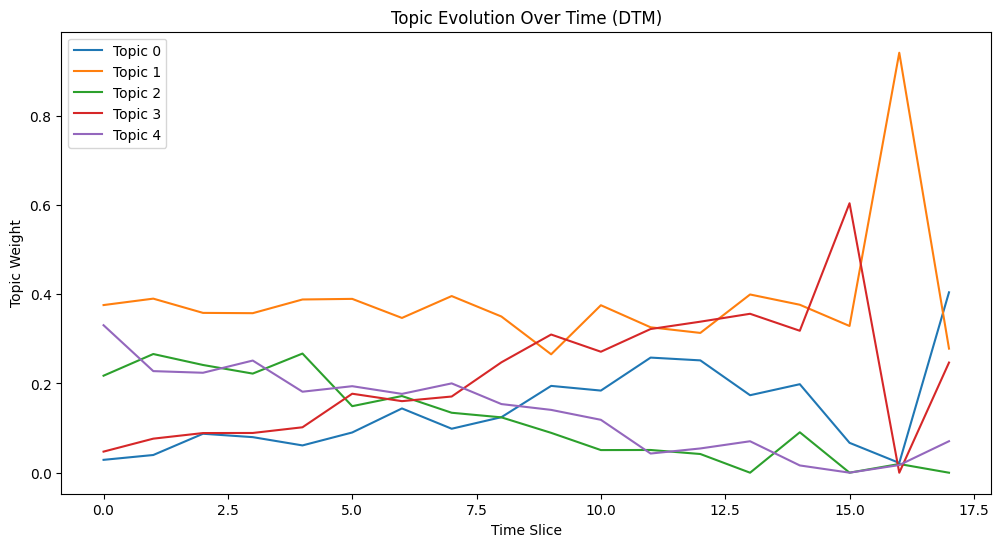

In [ ]:
num_topics = dtm.num_topics
time_steps = len(time_slices)
topic_trends = np.zeros((time_steps, num_topics))

for t in range(time_steps):
    # Get topic proportions for each document at time t
    doc_topic_dist = [dtm.doc_topics(d) for d in range(len(corpus)) if df['Year'].iloc[d] == df['Year'].unique()[t]]
    # Average topic proportions to get overall topic distribution at time t
    topic_weights = np.mean(doc_topic_dist, axis=0) if doc_topic_dist else np.zeros(num_topics) # Handle empty time slices
    topic_trends[t, :] = topic_weights  # Store topic weights

plt.figure(figsize=(12, 6))
for topic_idx in range(num_topics):
    plt.plot(range(time_steps), topic_trends[:, topic_idx], label=f"Topic {topic_idx}")

plt.xlabel("Time Slice")
plt.ylabel("Topic Weight")
plt.title("Topic Evolution Over Time (DTM)")
plt.legend()
plt.show()